使用裝置: cuda
Files already downloaded and verified
epoch: 1, stage: 1/5, batch: 0/157, loss: 1.173980712890625, noise level: 0.0
epoch: 1, stage: 2/5, batch: 0/157, loss: 0.8455194234848022, noise level: 0.3
epoch: 1, stage: 3/5, batch: 0/157, loss: 0.5710508227348328, noise level: 0.6
epoch: 1, stage: 4/5, batch: 0/157, loss: 0.3397654891014099, noise level: 0.8999999999999999
epoch: 1, stage: 5/5, batch: 0/157, loss: 0.2537004053592682, noise level: 1.2
epoch: 1, stage: 1/5, batch: 100/157, loss: 0.014801161363720894, noise level: 0.0
epoch: 1, stage: 2/5, batch: 100/157, loss: 0.022761516273021698, noise level: 0.3
epoch: 1, stage: 3/5, batch: 100/157, loss: 0.04053477942943573, noise level: 0.6
epoch: 1, stage: 4/5, batch: 100/157, loss: 0.06264500319957733, noise level: 0.8999999999999999
epoch: 1, stage: 5/5, batch: 100/157, loss: 0.0913439616560936, noise level: 1.2
epoch: 2, stage: 1/5, batch: 0/157, loss: 0.01648133248090744, noise level: 0.0
epoch: 2, stage: 2/5, batch: 0/157, 

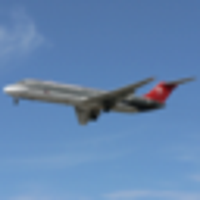

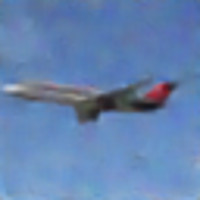

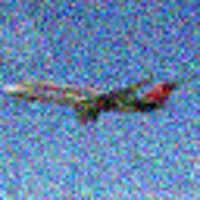

平均 MSE: 0.0015551176884066775
平均 RMSE: 0.03896582534123037


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")

# 定義資料集和轉換
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 調整大小至 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 使用 ImageNet 的均值和標準差進行正規化
])

# 使用 STL10 資料集作為示例
training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

# 定義簡單的卷積自編碼器模型
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SimpleAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 調整學習率
criterion = nn.MSELoss()

num_epochs = 10

# 定義多個去噪階段的程式碼
num_denoising_stages = 5  # 定義5個去噪階段

for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(train_dataloader):
        images = images.to(device)

        for stage in range(num_denoising_stages):
            # 隨機生成噪聲水平
            noise_level = 0.3 * stage  # 根據階段生成噪聲水平
            noisy_images = images + noise_level * torch.randn_like(images)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'epoch: {epoch+1}, stage: {stage+1}/{num_denoising_stages}, batch: {batch_idx}/{len(train_dataloader)}, loss: {loss.item()}, noise level: {noise_level}')


sample_image, _ = next(iter(train_dataloader))
sample_image = sample_image.to(device)

sample_np = sample_image[0].cpu().numpy().transpose(1, 2, 0)
sample_np = (sample_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
sample_np = np.clip(sample_np, 0, 1)
sample_pil = Image.fromarray((sample_np * 255).astype(np.uint8))

noisy_sample_image = sample_image + 0.5 * torch.randn_like(sample_image)

with torch.no_grad():
    reconstructed_image = model(noisy_sample_image)

reconstructed_image_np = reconstructed_image[0].cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = (reconstructed_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
reconstructed_image_pil = Image.fromarray((reconstructed_image_np * 255).astype(np.uint8))
reconstructed_image_pil.save('reconstructed_image.jpg')

noisy_sample_image_np = noisy_sample_image[0].cpu().numpy().transpose(1, 2, 0)
noisy_sample_image_np = (noisy_sample_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
noisy_sample_image_np = np.clip(noisy_sample_image_np, 0, 1)
noisy_sample_image_pil = Image.fromarray((noisy_sample_image_np * 255).astype(np.uint8))
noisy_sample_image_pil.save('noisy_sample_image.jpg')

from IPython.display import display
display(sample_pil.resize((200, 200)))

display(reconstructed_image_pil.resize((200, 200)))

display(noisy_sample_image_pil.resize((200, 200)))

# 計算 MSE 和 RMSE
mse_values = []
rmse_values = []

for i in range(len(reconstructed_image)):
    original_np = sample_image[i].cpu().numpy().transpose(1, 2, 0)
    original_np = (original_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反正規化
    original_np = np.clip(original_np, 0, 1)
    
    reconstructed_np = reconstructed_image[i].cpu().numpy().transpose(1, 2, 0)
    reconstructed_np = (reconstructed_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反正規化
    reconstructed_np = np.clip(reconstructed_np, 0, 1)
    
    mse = np.mean((original_np - reconstructed_np) ** 2)
    rmse = np.sqrt(mse)
    
    mse_values.append(mse)
    rmse_values.append(rmse)

print(f'平均 MSE: {np.mean(mse_values)}')
print(f'平均 RMSE: {np.mean(rmse_values)}')
